# Plotting of pretrained results


In [161]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import sys
import matplotlib.pyplot as plt
from master_data_functions.functions import *
from master_models.pretrained import pretrained_model
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:

# File import
# Sample filenames are:
# CeBr10kSingle_1.txt -> single events, 
# CeBr10kSingle_2.txt -> single events
# CeBr10k_1.txt -> mixed single and double events 
# CeBr10.txt -> small file of 10 samples
# CeBr2Mil_Mix.txt -> 2 million mixed samples of simulated events

# Flag import, since we can now import 200k events from .npy files
from_file = False
if from_file:

    folder = "simulated"
    filename = "CeBr2Mil_Mix.txt"
    num_samples = 2e5
    #folder = "sample"
    #filename = "CeBr10k_1.txt"
    #num_samples = 1e3

    data = import_data(folder=folder, filename=filename, num_samples=num_samples)
    images = data[filename]["images"]
    energies = data[filename]["energies"]
    positions = data[filename]["positions"]
    labels = to_categorical(data[filename]["labels"])
    n_classes = labels.shape[1]
else:
    images = load_feature_representation("images_noscale_200k.npy")
    energies = load_feature_representation("energies_noscale_200k.npy")
    positions = load_feature_representation("positions_noscale_200k.npy")
    labels = load_feature_representation("labels_noscale_200k.npy")

n_classes = labels.shape[1]
print("Number of classes: {}".format(n_classes))
print("Images shape: {}".format(images.shape))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
print("Labels shape: {}".format(labels.shape))


Number of classes: 2
Images shape: (200000, 16, 16, 1)
Energies shape: (200000, 2)
Positions shape: (200000, 4)
Labels shape: (200000, 2)


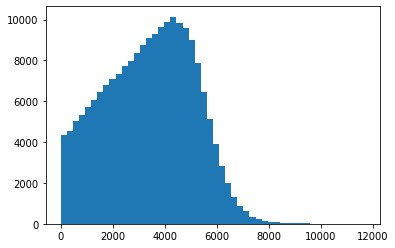

In [158]:
# Get max intensity for each image
max_intensities = np.amax(images[:,:,:,0], axis=(1,2))
plt.hist(max_intensities, bins=50)
plt.show()

In [159]:
images = normalize_image_data(images)
images = np.concatenate((images, images, images), axis=3)

## Classification with custom dense network
### Multiple dense model
Build a dense model for each pretrained model form which a feature representation has been saved.

In [6]:
# Keys: model names, Values: depth to compare at.
pretrained_models = {
    "DenseNet121":None, #8
    "DenseNet169":None, #8
    "DenseNet201":None, #8
    "InceptionResNetV2":None, #8
    "InceptionV3":None, #8
    "MobileNet":None, #8
    "MobileNetV2":None, #5
    "NASNetLarge":None, #4
    "NASNetMobile":None, #4
    "ResNet50":None, #8
    "VGG16":None,
    "VGG19":None,
    "Xception":None, #6
    }

# Load model

In [162]:
MODEL_PATH = "../../data/output/models/"
FIGURE_PATH = "../../reports/pretrained/figures/"
name = "DenseNet201-0.92.hdf5"

loaded_model = tf.keras.models.load_model(MODEL_PATH+name)

# Load feature representation
net = "DenseNet201"
depth = "full"
epochs = 5
# Load features
features_filename = net + "_d" + str(depth) + "_" + str(images.shape[0]) + "_new_"+".npy"
pretrained_features = load_feature_representation(features_filename)

x_idx = np.arange(pretrained_features.shape[0])
y_idx = np.arange(pretrained_features.shape[0])

# Split the data into training and test sets
train_idx, test_idx, whatever1, whatever2 = train_test_split(x_idx, y_idx, test_size = 0.2)    

test_positions = positions[test_idx]
train_positions = positions[train_idx]
test_energies = energies[test_idx]
train_energies = energies[train_idx]
y_test = labels[test_idx]
y_train = labels[train_idx]
x_train = pretrained_features[train_idx]
x_test = pretrained_features[test_idx]

tmp_predicted = loaded_model.predict(x_test)
tmp_results = tmp_predicted.argmax(axis=-1)

# indices, relative distances and relative energies for test set
single_indices, double_indices, close_indices = event_indices(test_positions)
rel_distance_test = relative_distance(test_positions)
energy_diff_test = energy_difference(test_energies)
rel_energy_test = relative_energy(test_energies)

# Separate correct and wrong classifications




In [163]:
correct_doubles = np.where(tmp_results[double_indices] == 1)[0]
wrong_doubles = np.where(tmp_results[double_indices] == 0)[0]

mean_correct = np.mean(rel_distance_test[double_indices][correct_doubles])
mean_wrong = np.mean(rel_distance_test[double_indices][wrong_doubles])
mean_all = np.mean(rel_distance_test[double_indices])

ratio_doubles = len(correct_doubles) / len(double_indices)

# Ratio of correctly classified double events with a distance between
# events < 3mm
n_close = len(close_indices)
n_close_correct = len(np.where(rel_distance_test[double_indices][correct_doubles] < 3.0)[0])
ratio_close = n_close_correct / n_close
print(len(correct_doubles))
print(len(wrong_doubles))

# Output
print("Mean dist all double events: ", mean_all)
print("Mean dist correct double events: ", mean_correct)
print("Mean dist wrong double events: ", mean_wrong)
print("Ratio of correctly classified double events: ", ratio_doubles)
print("Ratio correctly classified events with dist < 3mm: ", ratio_close)
print(n_close)
print(len(double_indices))
print(np.mean(energy_diff_test[np.where(energy_diff_test != -100)]))
print(19749/len(single_indices))
print(len(correct_doubles)/len(double_indices))

16985
3008
Mean dist all double events:  13.241860529511165
Mean dist correct double events:  13.955360226169104
Mean dist wrong double events:  9.213006690503484
Ratio of correctly classified double events:  0.8495473415695494
Ratio correctly classified events with dist < 3mm:  0.4388133498145859
809
19993
0.33320184253920926
0.9871045134203029
0.8495473415695494


# Plots

## Accuracy and loss

In [62]:
acc_filename = net + "_d" + str(depth) + "_" + str(pretrained_features.shape[0]) + "_accuracy"
loss_filename = net + "_d" + str(depth) + "_" + str(pretrained_features.shape[0]) + "_loss"

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(acc_filename)
plt.clf()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(loss_filename)
plt.clf()
    


NameError: name 'history' is not defined

## Confusion Matrix

Confusion matrix, without normalization
[[19606   356]
 [ 3031 17007]]


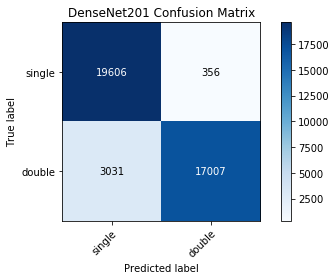

In [100]:
from analysis_functions.plotting import plot_confusion_matrix
classes = ["single", "double"]
title = net +" Confusion Matrix"
plot_confusion_matrix(y_test.argmax(axis=-1), tmp_results, classes, title=title)
plt.savefig(FIGURE_PATH+net+"_confmat.pdf", format="pdf")

## Cumulative Confusion Matrix

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from tqdm import tqdm
y_true = y_test.argmax(axis=-1)
# Get indices for sorted relative_distances

sorted_indices = np.argsort(rel_distance_test, axis=0)
sorted_dist = rel_distance_test[sorted_indices]
sorted_true = y_true[sorted_indices]
sorted_pred = tmp_results[sorted_indices]
# Calculate confusion matrices as a function of relative distance.
# Might include f1 score here too
conf_matrices = np.zeros((rel_distance_test.shape[0], 2, 2))
for i in tqdm(range(rel_distance_test.shape[0])):
    conf_matrices[i] = confusion_matrix(sorted_true[:i+1], sorted_pred[:i+1])




100%|██████████| 40000/40000 [08:01<00:00, 83.07it/s] 


In [62]:
# F1 scores
f1_scores = np.zeros((rel_distance_test.shape[0], 1))
for i in tqdm(range(rel_distance_test.shape[0])):
    f1_scores[i] = f1_score(sorted_true[:i+1], sorted_pred[:i+1])

  0%|          | 0/40000 [00:00<?, ?it/s]/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
100%|██████████| 40000/40000 [03:01<00:00, 220.15it/s]


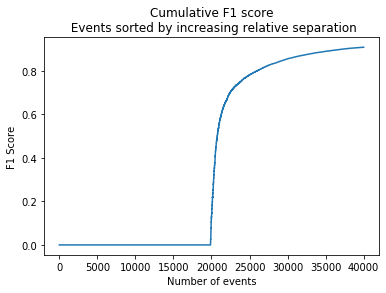

F1 Score full set: [0.90846121]


In [77]:
# Up until ~20k events there cannot be a true f1 score because
# that's where all the single events are.

plt.plot(np.arange(len(f1_scores)), f1_scores)
plt.title("Cumulative F1 score\n Events sorted by increasing relative separation")
plt.xlabel("Number of events")
plt.ylabel("F1 Score")
plt.show()

print("F1 Score full set:", f1_scores[-1])

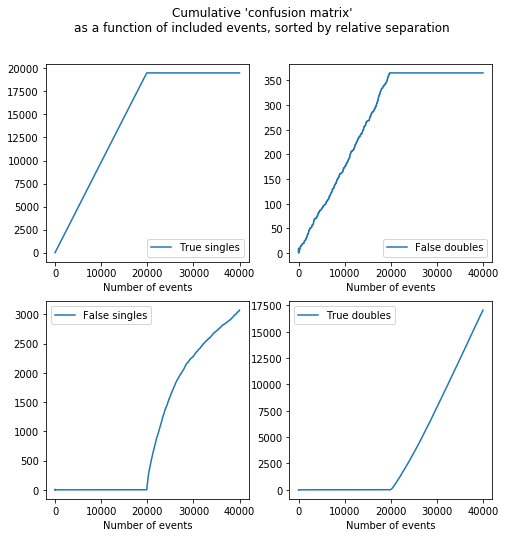

In [93]:
# Plot the confusion matrix values as subplots
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax[0,0].plot(conf_matrices[:,0,0], label="True singles")
ax[0,0].set_xlabel("Number of events")
ax[0,0].legend()
ax[0,1].plot(conf_matrices[:,0,1], label="False doubles")
ax[0,1].set_xlabel("Number of events")
ax[0,1].legend()
ax[1,0].plot(conf_matrices[:,1,0], label="False singles")
ax[1,0].set_xlabel("Number of events")
ax[1,0].legend()
ax[1,1].plot(conf_matrices[:,1,1], label="True doubles")
ax[1,1].set_xlabel("Number of events")
ax[1,1].legend()
fig.suptitle("Cumulative 'confusion matrix'\nas a function of included events, sorted by relative separation")
plt.show()
fig.savefig("cumulative_confmat.png", format="png")

### ROC curve for close events

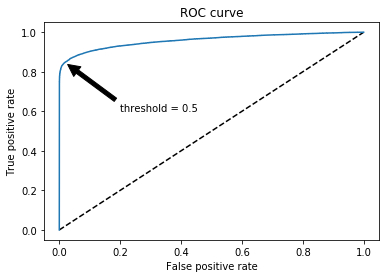

Area under curve: 0.9587677095450886


In [91]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_true, tmp_predicted[:,1])
idx = np.abs(thresholds - 0.5).argmin()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.annotate("threshold = 0.5", (fpr[idx], tpr[idx]),(0.2,0.6),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()


print("Area under curve:",roc_auc_score(y_true, tmp_predicted[:,1]))

# Distributions and scatterplot

## Test set

### Comparing correct and misclassified double events

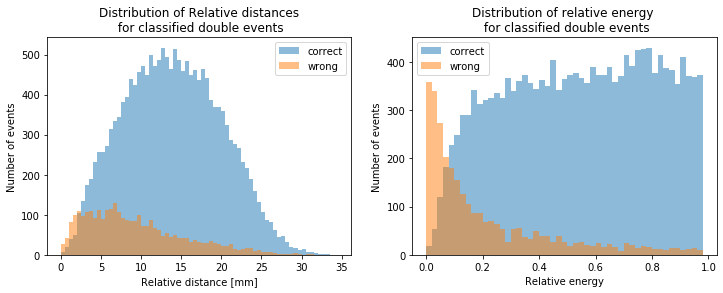

In [179]:
dist_bins = np.arange(0, np.amax(rel_distance_test), 0.5)
energy_bins = np.arange(0, np.amax(energy_diff_test), 0.02)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(rel_distance_test[double_indices][correct_doubles], bins=dist_bins, alpha=0.5, label="correct")
ax[0].hist(rel_distance_test[double_indices][wrong_doubles], bins=dist_bins, alpha=0.5, label="wrong")
ax[0].set_title("Distribution of Relative distances\n for classified double events")
ax[0].set_xlabel("Relative distance [mm]")
ax[0].set_ylabel("Number of events")
ax[0].legend()
ax[1].hist(rel_energy_test[double_indices][correct_doubles], bins=energy_bins, alpha=0.5, label="correct")
ax[1].hist(rel_energy_test[double_indices][wrong_doubles], bins=energy_bins, alpha=0.5, label="wrong")
ax[1].set_title("Distribution of relative energy \n for classified double events")
ax[1].set_xlabel("Relative energy")
ax[1].set_ylabel("Number of events")
ax[1].legend()
fig.savefig(FIGURE_PATH+net+"_relative_test_compare.pdf", format="pdf")

### Scatterplot relative distance vs. relative energy

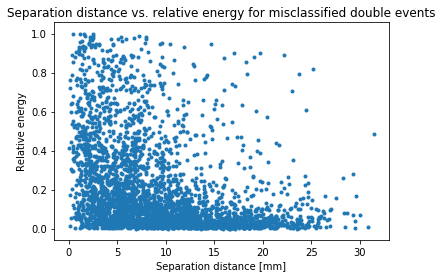

In [167]:
plt.scatter(
    rel_distance_test[double_indices][wrong_doubles], 
    rel_energy_test[double_indices][wrong_doubles],
    marker='.',
    )
plt.title("Separation distance vs. relative energy for misclassified double events")
plt.xlabel("Separation distance [mm]")
plt.ylabel("Relative energy")
plt.show()

### Images with high separation distance

In [172]:
high_relD = np.where(rel_distance_test[double_indices][wrong_doubles] > 25.0)[0]
high_relE = np.where(rel_energy_test[double_indices][wrong_doubles] > 0.2)[0]
high_both = np.array(list(set(high_relD).intersection(set(high_relE))))
print(len(high_both))



4


/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


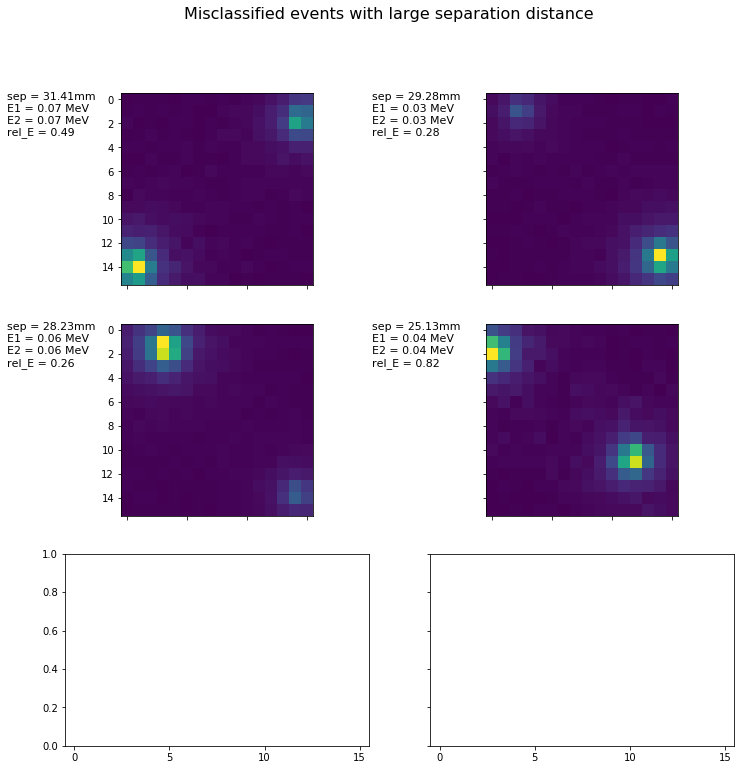

In [187]:
images_plot_high = images[test_idx][double_indices][wrong_doubles][high_both][:,:,:,0]
rel_pos_plot_high = rel_distance_test[double_indices][wrong_doubles][high_both]
rel_energy_plot_high = rel_energy_test[double_indices][wrong_doubles][high_both]
energy_plot_high = energies[test_idx][double_indices][wrong_doubles][high_both]
fig, ax = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(12,12))
for i in range(3):
    for j in range(2):
        if i*2+j >= len(high_both): break
        ax[i, j].imshow(images_plot_high[i*2 + j])
        rel_pos = rel_pos_plot_high[i*2 + j]
        rel_E = rel_energy_plot_high[i*2 + j]
        E1 = energy_plot_high[i*2 + j, 0]
        E2 = energy_plot_high[i*2 + j, 1]
        relp = "sep = {:.2f}mm".format(rel_pos[0])
        rele = "rel_E = {:.2f}".format(rel_E[0])
        e1_txt = "E1 = {:.2f} MeV".format(E1)
        e2_txt = "E2 = {:.2f} MeV".format(E1)
        ax[i, j].text(-10, 0, relp, fontsize=11)
        ax[i, j].text(-10, 1, e1_txt, fontsize=11)
        ax[i, j].text(-10, 2, e2_txt, fontsize=11)
        ax[i, j].text(-10, 3, rele, fontsize=11)
        
fig.suptitle("Misclassified events with large separation distance", fontsize=16)
#fig.savefig(FIGURE_PATH+net+"_misclassified_large_dist.pdf", format="pdf")
fig.show()

## Plots of events that no networks were able to classify correctly

In [19]:
# Load indices
OUTPUT_PATH = MODEL_PATH = "../../data/output/"
fname_indices = "never_correct_indices.txt"
never_correct = np.loadtxt(OUTPUT_PATH + fname_indices, dtype=int).tolist()

rel_distance_never = relative_distance(positions[never_correct])
energy_diff_never = energy_difference(energies[never_correct])



W0927 20:57:01.494150 139837202102080 legend.py:1282] No handles with labels found to put in legend.
W0927 20:57:01.523813 139837202102080 legend.py:1282] No handles with labels found to put in legend.


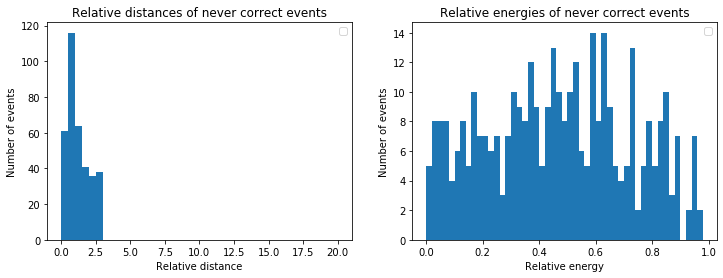

In [20]:
# Histograms
dist_bins = np.arange(0, np.amax(rel_distance_all), 0.5)
energy_bins = np.arange(0, np.amax(energy_diff_all), 0.02)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(rel_distance_all[never_correct], bins=dist_bins)
ax[0].set_title("Relative distances of never correct events")
ax[0].set_xlabel("Relative distance")
ax[0].set_ylabel("Number of events")
ax[0].legend()

ax[1].hist(energy_diff_all[never_correct], bins=energy_bins)
ax[1].set_title("Energy difference of never correct events")
ax[1].set_xlabel("Energy difference")
ax[1].set_ylabel("Number of events")
ax[1].legend()

fig.savefig(FIGURE_PATH+net+"_relative_noncorrect.pdf", format="pdf")

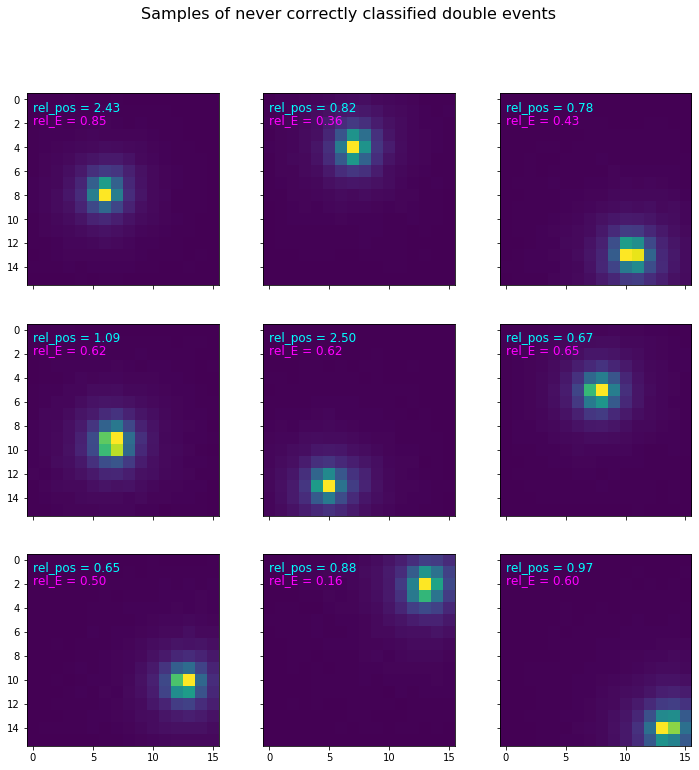

In [52]:
images_plot = images[never_correct][:,:,:,0]
rel_pos_plot = rel_distance_all[never_correct]
energy_diff_plot = energy_diff_all[never_correct]
fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))
index = 120
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(images_plot[index + i*3 + j])
        rel_pos = rel_pos_plot[index + i*3 + j]
        energy_diff = energy_diff_plot[index + i*3 + j]
        relp = "rel_pos = {:.2f}".format(rel_pos[0])
        rele = "diff_E = {:.2f}".format(energy_diff[0])
        ax[i, j].text(0,1, relp, color='cyan', fontsize=12)
        ax[i, j].text(0,2, rele, color='magenta', fontsize=12)
        
fig.suptitle("Samples of never correctly classified double events", fontsize=16)
fig.savefig(FIGURE_PATH+net+"_nocorrect_samples.pdf", format="pdf")
        

        

In [66]:
print(len(rel_pos_plot))

356


In [ ]:
# Plot some images, with electron origin positions
%matplotlib inline

images = images.reshape(images.shape[0],16,16)

fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))
for i in range(3):
    for j in range(3):
        # plot image
        ax[i, j].imshow(images[index + i*3 + j])
        
        # plot origin of event
        x = positions[index + i*3 + j, 0]
        y = positions[index + i*3 + j, 1]
        ax[i, j].plot(x, y, 'rx')
        ax[i, j].set_title('single')
        if positions[index + i*3 + j, 3] != -100:
            x2 = positions[index + i*3 + j, 2]
            y2 = positions[index + i*3 + j, 3]
            ax[i, j].plot(x2, y2, 'rx')
            ax[i, j].set_title('double')
        
plt.show()